In [1]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

In [ ]:
#client = bigquery.Client()
#sql = """
#SELECT * FROM `healthy-firefly-228503.airline06.air_06`
#"""
#air = client.query(sql).to_dataframe()
#air.head()

In [5]:
#air = pd.read_csv('2006.csv')

#client = language.LanguageServiceClient.from_service_account_json("/path/to/file.json")
#client = bigquery.Client()
#air = client.query("""
#    SELECT * FROM `healthy-firefly-228503.airline06.air_06`
#    """)
#air = query_job.result()

In [6]:
air = pd.read_csv('2006.csv')
air.head()

AttributeError: 'QueryJob' object has no attribute 'head'

In [3]:
air.shape

(7141922, 29)

In [4]:
nullvals = pd.DataFrame(air.isna().sum())

nullvals

,0
Year,0
Month,0
DayofMonth,0
DayOfWeek,0
DepTime,121934
CRSDepTime,0
ArrTime,138120
CRSArrTime,0
UniqueCarrier,0
FlightNum,0


## Explore the Data

In [82]:
air = air.drop(['CancellationCode'],1)
air = air.dropna()
air.shape

(7003337, 30)

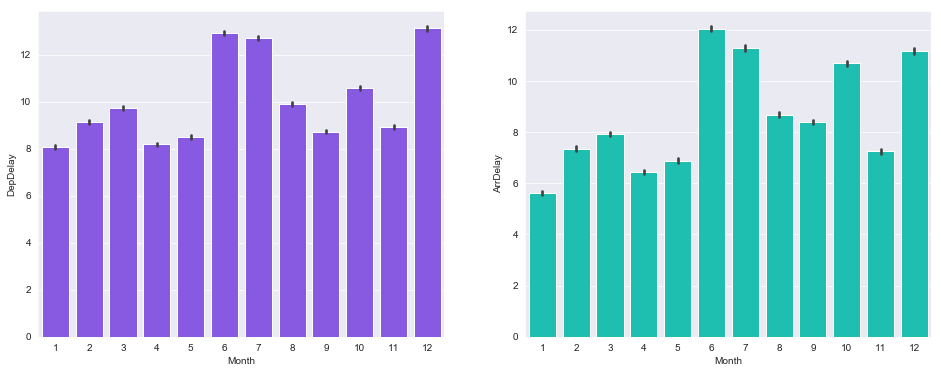

In [32]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.barplot(x='Month', y='DepDelay', data=air, color='#7F44F7')
plt.subplot(1,2,2)
sns.barplot(x='Month', y='ArrDelay', data=air, color='#03DAC6')
plt.show()

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


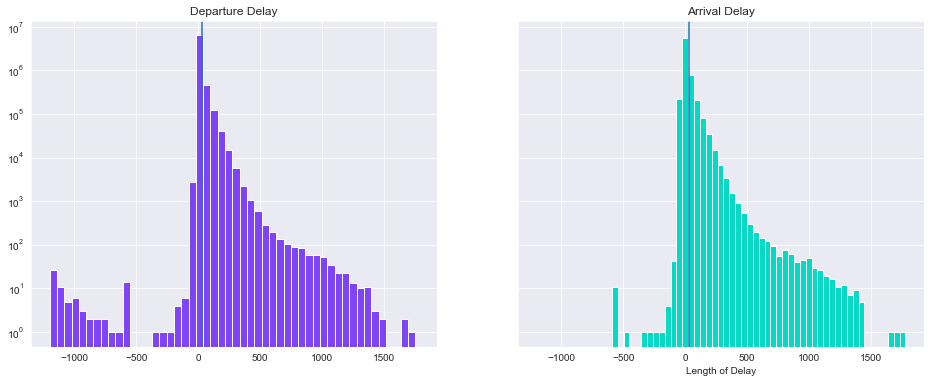

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True, figsize=(16,6))
ax1.hist(air.DepDelay, bins=50, color='#7F44F7')
# to show the limit of where a delay is defined or not
ax1.axvline(x=30)
ax1.set_title('Departure Delay')
ax2.hist(air.ArrDelay, bins=50, color='#03DAC6')
ax2.axvline(x=30)
ax2.set_title('Arrival Delay')
plt.xlabel('Length of Delay')

plt.ylabel('')
plt.yscale('log')
plt.show()

#### Key Points
- This data is transformed/scaled so we can get a more accurate view of it's distribution. The non transformed data shows a much larger imbalance between flights with no delays.
- What we do see here though is that most flights aren't delayed, and that the most common delays after that are just barely delayed.
- The data (almost) exponentially decreases as delays get longer
- This seems obvious but departure delays and arrival delays seem to be very correlated
- There are whole lot of negatively delayed flights. Which when over three hours early, it doesn't make all that much sense.

In [52]:
# More than 3 hours early doesn't seem to make much sense
air = air.drop(air[air.DepDelay < (-180)].index)
air = air.drop(air[air.ArrDelay < (-180)].index)

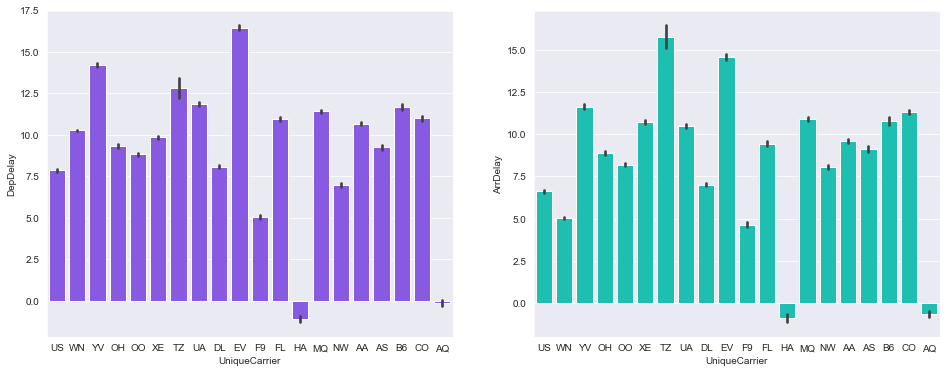

In [34]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.barplot(x='UniqueCarrier', y='DepDelay', data=air, color='#7F44F7')
plt.subplot(1,2,2)
sns.barplot(x='UniqueCarrier', y='ArrDelay', data=air, color='#03DAC6')
plt.show()

#### Key Points
- The different airlines seem pretty evenly distributed as far as how delayed they are.
- The obvious stand outs are Hawaiian Airlines(HA), Frontier(F9), and Express Jet (EV). Express Jet because of it's coniderably high rate of delays. Then Frontier and even more so Hawaiian for it's abilitity to keep delays to a minimum. In Hawaiian's case, that is even getting flights out early.
- Tsaradia(TZ) seems to have the most outliers compared to the other airlines, on top of what is a pretty high delay rate.

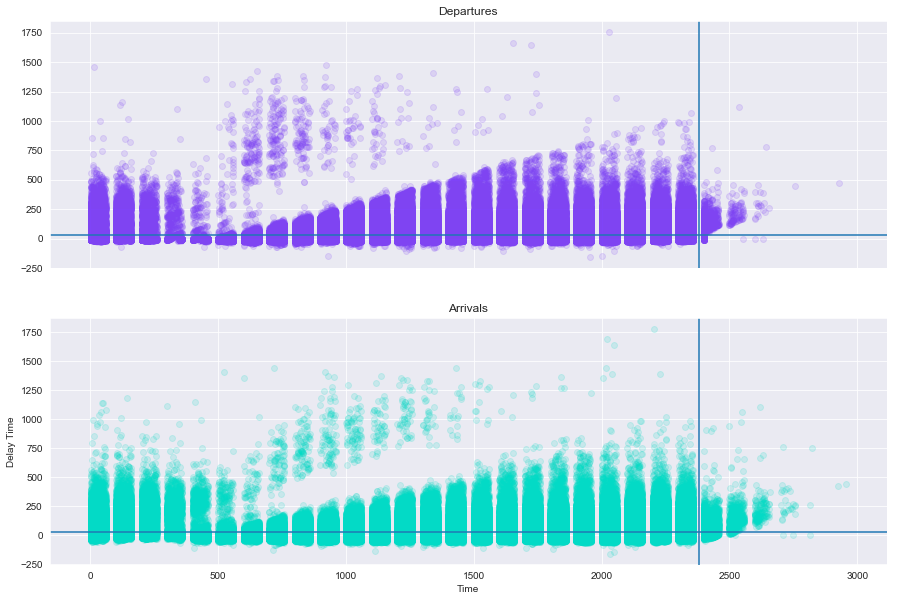

In [41]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,10))
ax1.scatter(x="DepTime", y="DepDelay", data=air, alpha=.15, color='#7F44F7')
# because delays over 30 min count as a delay
ax1.axhline(y=30)
# To show where the 24 hours starts/begins
ax1.axvline(x=2380)
ax1.set_title('Departures')
ax2.scatter(x="ArrTime", y="ArrDelay", data=air, alpha=.15, color='#03DAC6')
# because delays over 30 min count as a delay
ax2.axhline(y=30)
# To show where the 24 hours starts/begins
ax2.axvline(x=2380)
ax2.set_title('Arrivals')

plt.xlabel('Time')
plt.ylabel('Delay Time')
plt.show()

#### Key Points
- I have a feeling this data is a bit misleading, my thought is that there are probably a lot less delayed flights then there are on-time flights, so this makes it seem as if there are an even amount because of the shape of all of the data points.
- Despite that, there is a pattern here that show that as the day gets longer, the delays tend to get worse.
- The mornings have considerably less delays.
- It deos seem though that every so often an early flight can end up remarkably delayed. But put in the context of there more than likely being much more on time flights vs delayed flights, the possibility of such an extreme delay is probably very low.

In [74]:
# The braun of our data is below a 750 min delay, really so doing 800 is generous
air = air.drop(air[air.DepDelay > 800].index)
air = air.drop(air[air.ArrDelay > 800].index)

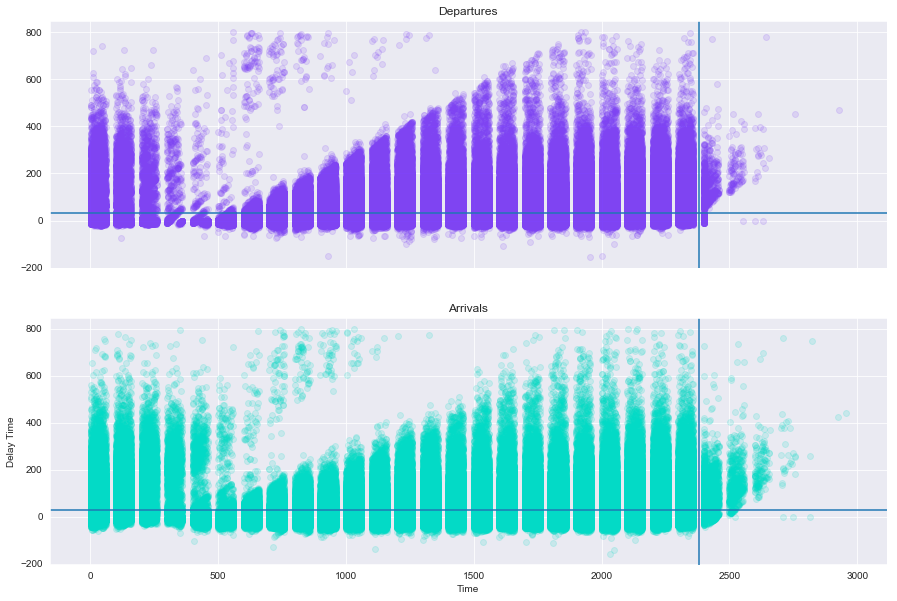

In [78]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,10))
ax1.scatter(x="DepTime", y="DepDelay", data=air, alpha=.15, color='#7F44F7')
# because delays over 30 min count as a delay
ax1.axhline(y=30)
# To show where the 24 hours starts/begins
ax1.axvline(x=2380)
ax1.set_title('Departures')
ax2.scatter(x="ArrTime", y="ArrDelay", data=air, alpha=.15, color='#03DAC6')
# because delays over 30 min count as a delay
ax2.axhline(y=30)
# To show where the 24 hours starts/begins
ax2.axvline(x=2380)
ax2.set_title('Arrivals')

plt.xlabel('Time')
plt.ylabel('Delay Time')
plt.show()

In [77]:
air.shape

(7141448, 31)

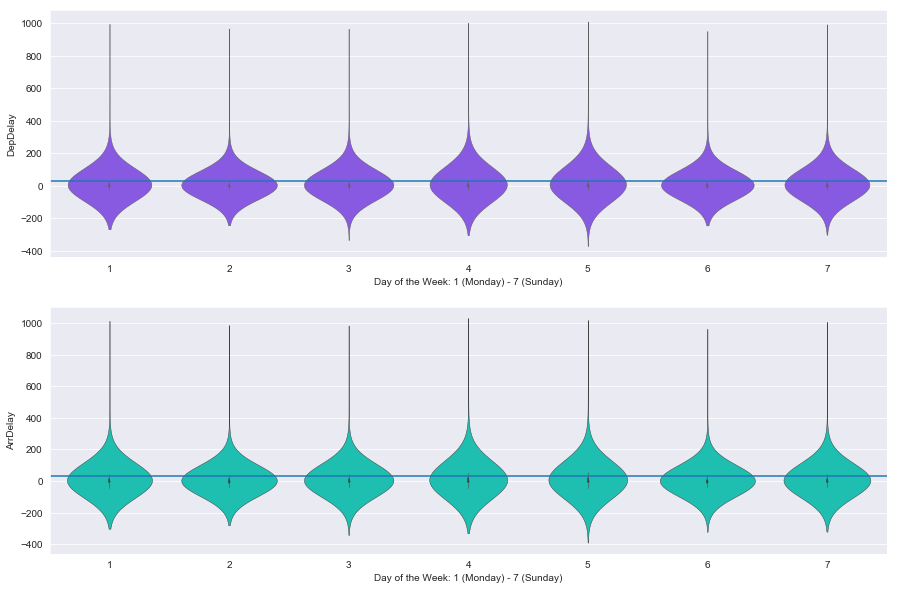

In [75]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.violinplot(x='DayOfWeek', y='DepDelay', data=air, color='#7F44F7', linewidth=.5, bw=3)
plt.xlabel('Day of the Week: 1 (Monday) - 7 (Sunday)')
plt.axhline(y=30)
plt.subplot(2,1,2)
sns.violinplot(x='DayOfWeek', y='ArrDelay', data=air, color='#03DAC6', linewidth=.5, bw=3)
plt.xlabel('Day of the Week: 1 (Monday) - 7 (Sunday)')
plt.axhline(y=30)
plt.show()

#### Key Points
- This graph proves an earlier point: the majority of flights are actually on time, with Wednesdays, Saturdays and Sundays having the highest volume of flights.
- Saturdays and Mondays seem to have the widest distributions of just barely delayed flights.
- Interestingly, the very worst delay happened on a Wednesday. This graph data is scaled to show the violen plot a little more accurately but even then, it is hard to tell just how often those outliers happen. My guess, based upon by how massive this dataset is that it happens very very rarely.
- It does seem like people fly more towards the end of the week though, from Wednesday through Friday.

In [27]:
delay_comp = pd.DataFrame()
delay_comp['departures'] = air.DepDelay.loc[air.DepDelay>30].describe()
delay_comp['arrivals'] = air.ArrDelay.loc[air.ArrDelay>30].describe()
delay_comp

,departures,arrivals
count,831490.000000,932517.000000
mean,78.072428,77.832746
std,59.448106,59.198320
min,31.000000,31.000000
25%,42.000000,41.000000
50%,59.000000,59.000000
75%,93.000000,93.000000
max,1752.000000,1779.000000


#### When Looking at the Descriptions:
- The average delay is a about 1 hour and 15 minutes, this is with a fairly large amount of variance though.
- The max delay is ridiculously long and very obviously an outlier.

In [57]:
# create binary variables of 
air['DepDelay_bin'] = np.where(air['DepDelay']>30,1,0)
air['ArrDelay_bin'] = np.where(air['ArrDelay']>30,1,0)

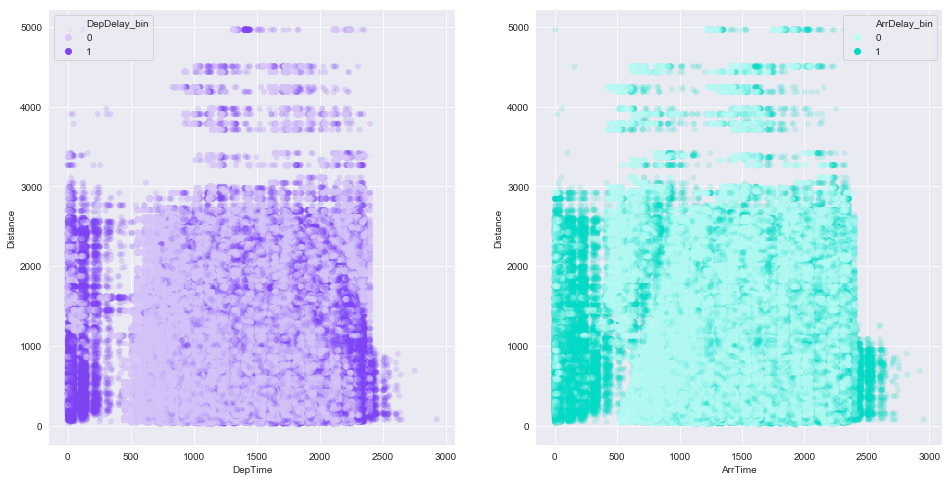

In [72]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
color1={0:'#d9c8fd', 1:'#7F44F7'}
color2={0:'#b7fef7', 1:'#03DAC6'}
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="DepTime", y="Distance", hue='DepDelay_bin',
                palette=color1, linewidth=0,
                data=air, ax=ax1, alpha=.15)
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="ArrTime", y="Distance", hue='ArrDelay_bin',
                palette=color2, linewidth=0,
                data=air, ax=ax2, alpha=.15)

---

**Two questions**
- Can you have negative delays that massive?
- There are more than 24 time blocks, how does that work?

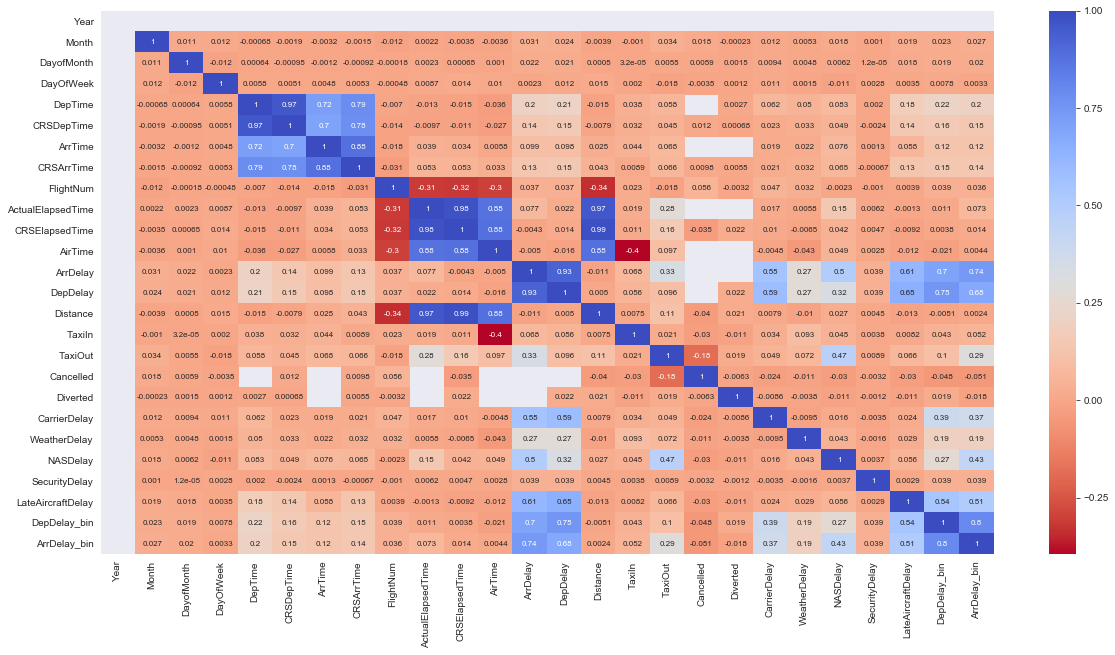

In [58]:
plt.figure(figsize=(20,10))
sample_corr = air.corr()
sns.heatmap(sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':8})
ax2.set_title('Correlation Matrix', fontsize=14)
plt.show()

In [35]:
air[['UniqueCarrier','DepTime','ArrTime','ArrDelay', 'DepDelay','CarrierDelay','WeatherDelay','NASDelay',
     'SecurityDelay','LateAircraftDelay']].loc[air['DepTime']>2400].shape

(547, 10)

In [81]:
air.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'DepDelay_bin', 'ArrDelay_bin'],
      dtype='object')

## Modeling

In [84]:
air.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn                 int64
TaxiOut                int64
Cancelled              int64
Diverted               int64
CarrierDelay           int64
WeatherDelay           int64
NASDelay               int64
SecurityDelay          int64
LateAircraftDelay      int64
DepDelay_bin           int64
ArrDelay_bin           int64
dtype: object

In [86]:
air[['UniqueCarrier','FlightNum', 'TailNum','Origin', 'Dest']].head(3)

,UniqueCarrier,FlightNum,TailNum,Origin,Dest
0,US,343,N657AW,ATL,PHX
1,US,613,N834AW,ATL,PHX
2,US,617,N605AW,ATL,PHX


In [88]:
air.FlightNum = pd.to_numeric(air.FlightNum)

In [90]:
from sklearn.feature_selection import SelectKBest, f_classif

X = air.drop(['ArrDelay', 'DepDelay','DepDelay_bin', 'ArrDelay_bin', 'CarrierDelay','WeatherDelay','NASDelay',
     'SecurityDelay','LateAircraftDelay','UniqueCarrier', 'TailNum','Origin', 'Dest'], 1)
y = air['DepDelay']

selector=SelectKBest(score_func=f_classif,k=17)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.head(20).values

scores

/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0 15 16] are constant.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Attribute,F Score,P Value,Support
4,DepTime,723.681083,0.0,True
5,CRSDepTime,445.088093,0.0,True
7,CRSArrTime,387.639593,0.0,True
6,ArrTime,360.022104,0.0,True
8,FlightNum,178.719472,0.0,True
14,TaxiOut,130.132903,0.0,True
1,Month,95.493556,0.0,True
9,ActualElapsedTime,65.516271,0.0,True
12,Distance,64.994020,0.0,True
10,CRSElapsedTime,63.343756,0.0,True


**Select K Best:**
- We'll drop Year, Cancelled and Diverted when we make the models.
- It makes sense that arrival and departure time have such a weighted effect on the data.
- Interesting that flight number is so high as well

In [91]:
X = air.drop(['ArrDelay', 'DepDelay','DepDelay_bin', 'ArrDelay_bin', 'CarrierDelay','WeatherDelay','NASDelay',
              'SecurityDelay','LateAircraftDelay','UniqueCarrier', 'TailNum','Origin', 'Dest', 'Year', 
              'Cancelled', 'Diverted'], 1)
y = air['DepDelay']

In [92]:
# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Logistic Regression

In [ ]:
# get rid of the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e9, max_iter = 150)
lr.fit(x_train, y_train)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

In [ ]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'C':[1e9,.1,.25,.5,.75,1,2,3,5], 'max_iter':[25,50,100,150,200,300,500], 'penalty':['l1','l2']}

# Start the grid search again
grid_DT = GridSearchCV(lr, param_grid, cv=5, verbose=3)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:')
grid_DT.cv_results_.keys()